In [1]:
using Revise
using RxInfer, Random, Distributions, Plots, Flux, DelimitedFiles, StableRNGs
using ReactiveMP
using CCMP
using Base
using SpecialFunctions
using BenchmarkTools
using StatsFuns

  ** incremental compilation may be fatally broken for this module **



In [2]:
# to check that matched with Semih
sunspot_semih = readdlm("data/SN_Akbayrak.csv")
semih_observations = map(Int, sunspot_semih[:,2]);

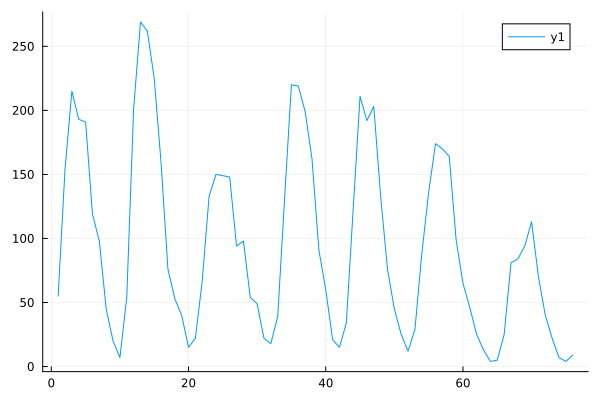

In [3]:
sunspot = readdlm("data/SN_y_tot_V2.0.csv", ';')
select_1945_2020 = filter((s) -> s[1] > 1945 && s[1] < 2021, collect(eachrow(sunspot)))
observations = map((s) -> round(s[2]), select_1945_2020)
not_rounded = map((s) -> s[2], select_1945_2020)
@assert semih_observations == observations
plot(observations)


In [4]:
hello(x) = softplus(x)

@meta function sunspot_meta(rng, nr_samples, nr_iterations, optimizer)
    hello() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 100, Val(true), true)
end;

@model function sunspot_model(nr_observations)

    γ ~ GammaShapeRate(1000.0, 2)
    z = randomvar(nr_observations)
    y = datavar(Float64, nr_observations)
    
    # specify estimate of initial location
    z[1] ~ GammaShapeRate(1, γ)
    y[1] ~ Poisson(z[1])
    for t in 2:nr_observations
        # specify state transition model
        z[t] ~ GammaShapeRate(identity(z[t-1]), γ)
        y[t] ~ Poisson(z[t])
    end
end

@meta function sunspot_meta(rng, nr_samples, nr_iterations, optimizer)
    identity() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 100, Val(true), false)
end;

@constraints function sunspot_constraints()
    q(γ, z) = q(γ)q(z)
    q(z) = q(z[begin])..q(z[end])
end;

@rule GammaShapeRate(:β, Marginalisation) (q_out::Gamma, q_α::SampleList, ) = begin 
    return GammaShapeRate(mean(q_α)+1, mean(q_out))
end

In [5]:
@average_energy GammaShapeRate (q_out::Any, q_α::SampleList, q_β::Any) = begin
    q_α_mean = mean(q_α)
    q_α_var = var(q_α)
    q_α_matched = GammaShapeRate(q_α_mean^2/q_α_var, q_α_mean/q_α_var)
    mean(loggamma, q_α_matched) - mean(q_α) * mean(log, q_β) - (mean(q_α_matched) - 1.0) * mean(log, q_out) + mean(q_β) * mean(q_out)
end

In [6]:
# z_init = map(r -> NormalMeanPrecision(r, 10), 1:50)
nr_observations = length(observations)
@time results = inference(
    model = sunspot_model(nr_observations),
    data = (y = observations,),
    iterations = 10,
    free_energy = true,
    constraints = sunspot_constraints(),
    meta = sunspot_meta(StableRNG(42), 1000, 10, Flux.Descent(0.001)),
    initmarginals = (γ=Gamma(2, 1), z=Gamma(2, 1))
)

 20.187207 seconds (87.22 M allocations: 4.468 GiB, 3.45% gc time, 97.50% compilation time: 0% of which was recompilation)


Inference results:
  Posteriors       | available for (γ, z)
  Free Energy:     | Real[7263.11, 6318.32, 6265.64, 6261.72, 6262.76, 6264.23, 6263.35, 6262.09, 6262.85, 6262.32]


In [7]:
@benchmark inference(
    model = sunspot_model(nr_observations),
    data = (y = observations,),
    iterations = 10,
    free_energy = true,
    constraints = sunspot_constraints(),
    meta = sunspot_meta(StableRNG(42), 1000, 10, Flux.Descent(0.001)),
    initmarginals = (γ=Gamma(2.0, 1), z=Gamma(2.0, 1))
)

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  447.855 ms … 470.701 ms  ┊ GC (min … max): 3.45% … 6.79%
 Time  (median):     454.468 ms               ┊ GC (median):    3.57%
 Time  (mean ± σ):   455.430 ms ±   6.462 ms  ┊ GC (mean ± σ):  4.15% ± 1.30%

  ▁     ▁▁     ▁  ▁█ ▁▁                     ▁                 ▁  
  █▁▁▁▁▁██▁▁▁▁▁█▁▁██▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  448 ms           Histogram: frequency by time          471 ms <

 Memory estimate: 212.82 MiB, allocs estimate: 5736444.

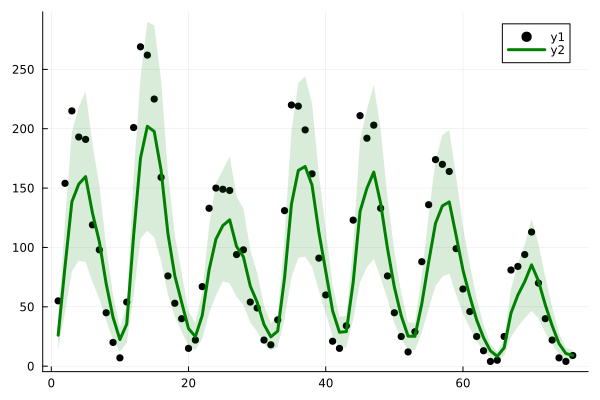

In [8]:
# plot estimates for location
posteriours = results.posteriors[:z][end]
means = map(mean, posteriours) 
ribbon = map(x -> var(x), posteriours)

p1 = scatter(observations,color=:black)

plot!(means, ribbon=ribbon, fillalpha=0.15, linewidth=3, color = :green)


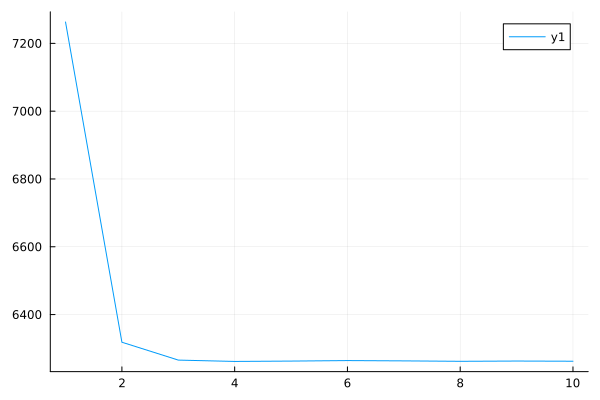

In [20]:
plot(results.free_energy[1:end])

In [21]:
open("estimations/cvi_sunspot_results.csv", "w") do io
    writedlm(io, [means ribbon])
end

open("estimations/cvi_fe_sunspot_results.csv", "w") do io
    writedlm(io, [results.free_energy])
end

In [22]:
sqrt(mean((not_rounded - means).^2))

34.404404002391445